# Insurance Cost Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/medical_insurance_dataset.csv'

### Importing the dataset

In [3]:
df= pd.read_csv(path, header=None)
df.head(10)

,0,1,2,3,4,5,6
0,19,1,27.900,0,1,3,16884.92400
1,18,2,33.770,1,0,4,1725.55230
2,28,2,33.000,3,0,4,4449.46200
3,33,2,22.705,0,0,1,21984.47061
4,32,2,28.880,0,0,1,3866.85520
5,31,1,25.740,0,?,4,3756.62160
6,46,1,33.440,1,0,4,8240.58960
7,37,1,27.740,3,0,1,7281.50560
8,37,2,29.830,2,0,2,6406.41070
9,60,1,25.840,0,0,1,28923.13692


In [4]:
headers= ["age", "gender", "bmi", "no_of_children", "smoker", "region", "charges"]
df.columns=headers

In [5]:
df.replace('?', np.nan, inplace=True)
df.head()

,age,gender,bmi,no_of_children,smoker,region,charges
0,19,1,27.900,0,1,3,16884.92400
1,18,2,33.770,1,0,4,1725.55230
2,28,2,33.000,3,0,4,4449.46200
3,33,2,22.705,0,0,1,21984.47061
4,32,2,28.880,0,0,1,3866.85520


### Data Wrangling

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2768 non-null   object 
 1   gender          2772 non-null   int64  
 2   bmi             2772 non-null   float64
 3   no_of_children  2772 non-null   int64  
 4   smoker          2765 non-null   object 
 5   region          2772 non-null   int64  
 6   charges         2772 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 151.7+ KB


**Handling the missing data:** 
- For continuous attributes (e.g., age), replacing missing values with the mean.
- For categorical attributes (e.g., smoker), replacing missing values with the most frequent value.
- Updating the data types of the respective columns.
- Verifing the update using .info().

In [7]:
# smoker is a categorical attribute, replaced with most frequent entry
is_smoker = df['smoker'].value_counts().idxmax()
df["smoker"].replace(np.nan, is_smoker, inplace=True)

# age is a continuous variable, replaced with mean age
mean_age = df['age'].astype('float').mean(axis=0)
df["age"].replace(np.nan, mean_age, inplace=True)

# Updating data types
df[["age","smoker"]] = df[["age","smoker"]].astype("int")

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2772 non-null   int32  
 1   gender          2772 non-null   int64  
 2   bmi             2772 non-null   float64
 3   no_of_children  2772 non-null   int64  
 4   smoker          2772 non-null   int32  
 5   region          2772 non-null   int64  
 6   charges         2772 non-null   float64
dtypes: float64(2), int32(2), int64(3)
memory usage: 130.1 KB
None


In [8]:
df["charges"]=np.round(df["charges"], 2)
df.head()

,age,gender,bmi,no_of_children,smoker,region,charges
0,19,1,27.900,0,1,3,16884.92
1,18,2,33.770,1,0,4,1725.55
2,28,2,33.000,3,0,4,4449.46
3,33,2,22.705,0,0,1,21984.47
4,32,2,28.880,0,0,1,3866.86


### Exploratory Data Analysis

(0.0, 66902.85800000001)

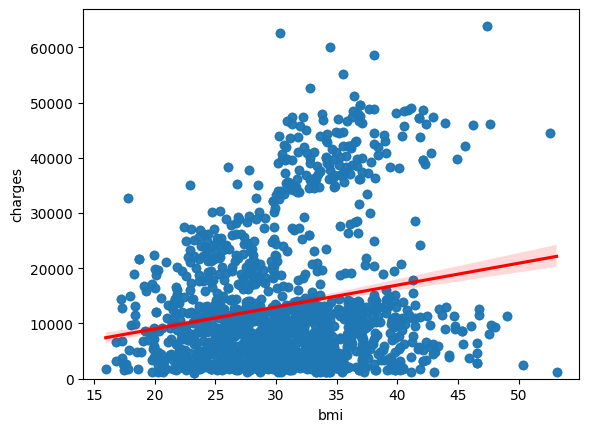

In [9]:
# regression plot for charges with respect to bmi
sns.regplot(x="bmi", y="charges", data=df, line_kws={"color": "red"})
plt.ylim(0,)

<Axes: xlabel='smoker', ylabel='charges'>

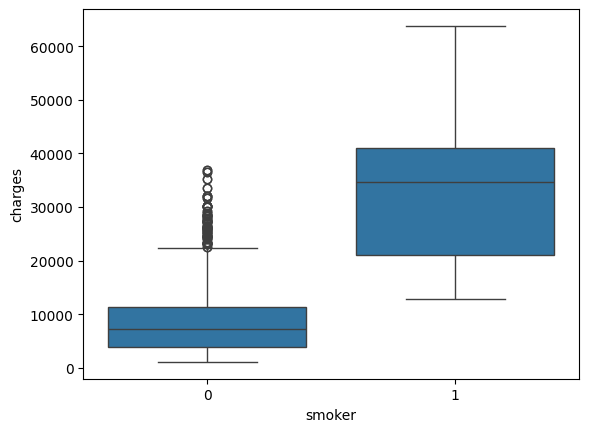

In [10]:
# box plot for charges with respect to smoker
sns.boxplot(x="smoker", y="charges", data=df)

In [11]:
# correlation matrix for the dataset
df.corr()

,age,gender,bmi,no_of_children,smoker,region,charges
age,1.000000,-0.026046,0.113048,0.037574,-0.023286,-0.007167,0.298624
gender,-0.026046,1.000000,0.042924,0.016020,0.082326,0.022213,0.062837
bmi,0.113048,0.042924,1.000000,-0.001492,0.011489,0.271119,0.199846
no_of_children,0.037574,0.016020,-0.001492,1.000000,0.006362,-0.025717,0.066442
smoker,-0.023286,0.082326,0.011489,0.006362,1.000000,0.054077,0.788783
region,-0.007167,0.022213,0.271119,-0.025717,0.054077,1.000000,0.054058
charges,0.298624,0.062837,0.199846,0.066442,0.788783,0.054058,1.000000


### Model Development

In [12]:
# predicting the charges value just by using the smoker attribute of the dataset
X = df[['smoker']]
Y = df['charges']
lm = LinearRegression()
lm.fit(X,Y)
print(lm.score(X, Y))

0.6221791733924185


In [13]:
# predicting the charges value, just by using all other attributes of the dataset.
Z=df[["age", "gender", "bmi", "no_of_children", "smoker", "region"]]
lm.fit(Z,Y)
print(lm.score(Z,Y))

0.7504083820289634


In [14]:
# Creating a training pipeline that can predict the charges value using all the other attributes of the dataset.
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False)), ('model',LinearRegression())]
pipe=Pipeline(Input)
Z=Z.astype(float)
pipe.fit(Z, Y)
ypipe=pipe.predict(Z)
print(r2_score(Y, ypipe))

0.8452357658607585


### Model Refinement

In [15]:
x_train,x_test, y_train, y_test=train_test_split(Z,Y,test_size=0.2, random_state=1)

In [16]:
RidgeModel=Ridge(alpha=0.1)
RidgeModel.fit(x_train, y_train)
yhat=RidgeModel.predict(x_test)
print(r2_score(y_test, yhat))

0.6760807731582404


In [17]:
# Applying polynomial transformation to the training parameters with degree=2
pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train)
x_test_pr=pr.fit_transform(x_test)
RidgeModel.fit(x_train_pr,y_train)
y_hat=RidgeModel.predict(x_test_pr)
print(r2_score(y_test,y_hat))

0.7835631107608142
